In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
import numpy as np
import scipy as sp
import h5py
from scipy.interpolate import interp1d
from scipy.linalg import sqrtm, solve_sylvester, solve_lyapunov
import matplotlib.pyplot as plt
import sys
import pseudo
import os
import glob
import miscUtil
import ops
%matplotlib inline

os.environ['DATA'] = os.environ['DATA186']
physDataDir = os.environ['DATA'] + 'phys/'
specDataDir = os.environ['DATA'] + 'spec/'
covDataDir = os.environ['DATA'] + 'cov/'
libDir = os.environ['LINLIB']
figureFolder = 'figures/'

# Max amplification for laminar base
Jovanovic & Bamieh (2005) JFM

In [3]:
N=100
aArr = 10**np.linspace(-4., 0.5, 30)
bArr = 10**np.linspace(-2., 1.2, 60)
H2normArr = np.zeros((aArr.size, bArr.size))
H2normArrTest = np.zeros((aArr.size, bArr.size))

for ind0 in range(aArr.size):
    a = aArr[ind0]
    for ind1 in range(bArr.size):
        b = bArr[ind1]
        k2 = a**2 + b**2
        I = np.identity(N); Z = np.zeros((N,N), dtype=np.complex)
        covMat = np.identity(3*N)
        statInst = ops.statComp(Re=2000., a=a, b=b, N=N, covMat = covMat)
        statInst.U = 1. - statInst.y**2
        statInst.dU = -2.*statInst.y
        statInst.d2U = -2.*np.ones(N)
        Umat = np.diag(statInst.U)
        dUmat = np.diag(statInst.dU)
        d2Umat = np.diag(statInst.d2U)
        Re = statInst.Re
        
        A, C, B = statInst.makeSystem()
        Badj = C.copy()
        Cadj = B.copy()
        
        # Building Aadj:
        Aadj = np.zeros((2*N, 2*N), dtype=np.complex)
        Delta = statInst.D2 - k2 * I
        DeltaInv = np.linalg.solve(Delta, I)
        Aadj11 = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + \
                1./Re*DeltaInv @ (Delta @ Delta)
        Aadj22 = 1.j*a*Umat + 1./Re*Delta
        Aadj21 = -1.j*b*DeltaInv @ dUmat
        
        Aadj = np.vstack(( 
                np.hstack(( Aadj11, Aadj21 )),
                np.hstack((  Z    , Aadj22 ))   ))
        
        # Solve Sylvester equation, AX + XB = Q, arguments to the function are A,B,Q
        # In present formulation, the equation is AX + X A* = - B B*
        X = solve_sylvester(A, Aadj, - B @ Badj)
                
        
        H2normArr[ind0,ind1] = np.sqrt(np.trace( X @ Cadj @ C))
        

Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0001 0.01 2000.0


/home/svadarevu/linenv/lib/python3.5/site-packages/ipykernel/__main__.py:44: ComplexWarning: Casting complex values to real discards the imaginary part


Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0001 0.0113301924881 2000.0
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0001 0.0128373261818 2000.0
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Usi

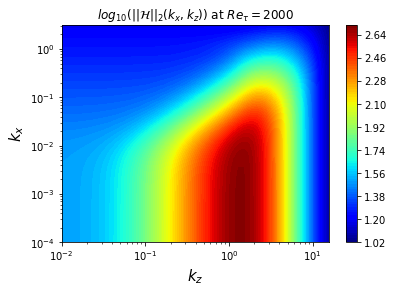

In [4]:
plt.contourf(bArr, aArr, np.log10(H2normArr),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}||_2 (k_x,k_z))$ at $Re_\\tau = 2000$")
plt.savefig('figures/'+'gainLaminar.pdf',format='pdf')
plt.show()

# Max amplification for turbulent base
Moarref et. al. 2013 (JFM); Model based scaling

Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150


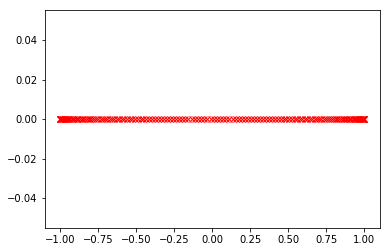

a, b, Re: 17.978885957543874 125.85220170280711 2003.0


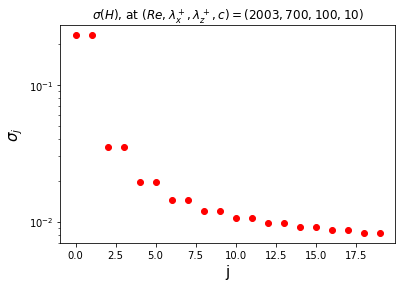

In [62]:
Re = 2003.; alfa = 25.4; kapa = 0.426; N = 150

# Fig 4.a in paper is for lx+ = 700, lz+ = 100, c = 10
# a = 2*pi/lx = 2*pi/(lx+ /ReTau) = ReTau * 2*pi/lx+
a = 2.*np.pi*Re/700.
b = 2.*np.pi*Re/100.
c = 10.; omega = a*c


statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
plt.plot(statInst.y, statInst.U - ops.turbMeanChannel(N=N,Re=Re,alfa=alfa,kapa=kapa)['U'],'rx'); plt.show()

A = statInst.OSS(a=a,b=b)
C = statInst.velVor2primitivesMat(a=a,b=b)
Cadj = statInst.primitives2velVorMat(a=a,b=b)
R = ( 1.j*omega*np.identity(2*N) + A )
R = - np.linalg.solve(R,np.identity(R.shape[0]))
H = C @ R @ Cadj
H = statInst._weightMat(H)

U,S,V = np.linalg.svd(H)
plt.plot(np.arange(20),S[:20],'ro')
plt.yscale("log")
plt.xlabel("j",fontsize=15); plt.ylabel("$\\sigma_j$",fontsize=15)
plt.title("$\\sigma(H)$, at $(Re,\\lambda^+_x,\\lambda^+_z,c)=(2003,700,100,10)$")
plt.savefig(figureFolder+'svalsRe2003lx700lz100.pdf',format='pdf')
plt.show()

In [34]:
N=150; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,30)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = statInst.U[5]; omega = a*c
        
        A = statInst.OSS(a=a,b=b)
        C = statInst.velVor2primitivesMat(a=a,b=b)
        Cadj = statInst.primitives2velVorMat(a=a,b=b)
        R = ( 1.j*omega*np.identity(2*N) + A )
        R = - np.linalg.solve(R,np.identity(R.shape[0]))
        H = C @ R @ Cadj
        H = statInst._weightMat(H)

        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: ps

In [35]:
N=150; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,30)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm_yp100 = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = 16.2; omega = a*c
        # This c is roughly U(yp=100)
        
        A = statInst.OSS(a=a,b=b)
        C = statInst.velVor2primitivesMat(a=a,b=b)
        Cadj = statInst.primitives2velVorMat(a=a,b=b)
        R = ( 1.j*omega*np.identity(2*N) + A )
        R = - np.linalg.solve(R,np.identity(R.shape[0]))
        H = C @ R @ Cadj
        H = statInst._weightMat(H)

        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm_yp100[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: ps

In [36]:
N=150; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,30)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm_y02 = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = 19.7; omega = a*c
        # This c is roughly U(y=0.2)
        
        A = statInst.OSS(a=a,b=b)
        C = statInst.velVor2primitivesMat(a=a,b=b)
        Cadj = statInst.primitives2velVorMat(a=a,b=b)
        R = ( 1.j*omega*np.identity(2*N) + A )
        R = - np.linalg.solve(R,np.identity(R.shape[0]))
        H = C @ R @ Cadj
        H = statInst._weightMat(H)

        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm_y02[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: ps

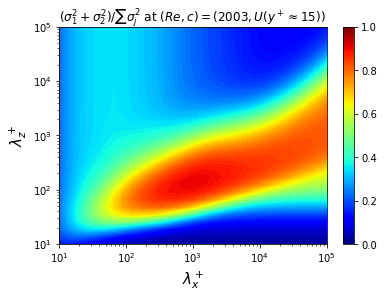

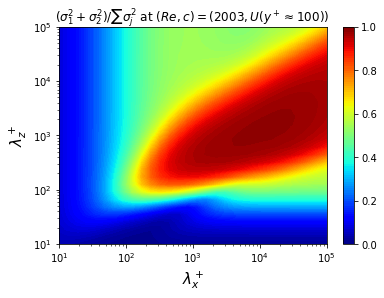

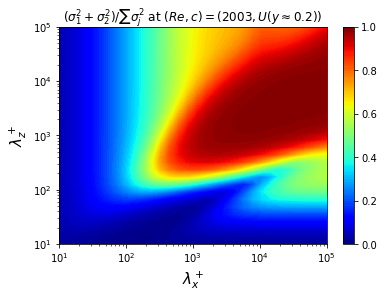

In [54]:
levels = np.linspace(0.,1.0,101)
cticks = np.linspace(0.,1.,6)

plt.contourf(lxpArr, lzpArr, svals2norm.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y^+\\approx 15))$")
plt.savefig(figureFolder+'svals12norm_yp15.pdf',format='pdf')
plt.show()

plt.contourf(lxpArr, lzpArr, svals2norm_yp100.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y^+\\approx 100))$")
plt.savefig(figureFolder+'svals12norm_yp100.pdf',format='pdf')
plt.show()

plt.contourf(lxpArr, lzpArr, svals2norm_y02.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y\\approx 0.2))$")
plt.savefig(figureFolder+'svals12norm_y02.pdf',format='pdf')
plt.show()

# Max amplification for turbulent base
Comparing with Moarref et. al. 2013 (JFM); Model based scaling
using the formulation of Jovanovic & Bamieh 2005

Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 17.978885957543874 125.85220170280711 2003.0


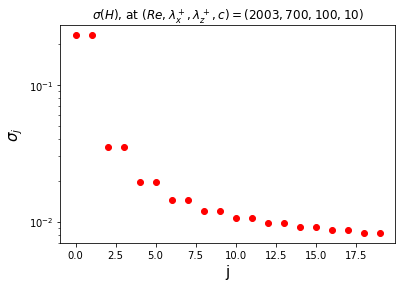

In [64]:
Re = 2003.; alfa = 25.4; kapa = 0.426; N = 150

# Fig 4.a in paper is for lx+ = 700, lz+ = 100, c = 10
# a = 2*pi/lx = 2*pi/(lx+ /ReTau) = ReTau * 2*pi/lx+
a = 2.*np.pi*Re/700.
b = 2.*np.pi*Re/100.
c = 10.; omega = a*c


statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))

A, C, B = statInst.makeSystem()
I = np.identity(A.shape[0])
R = (1.j*omega*I + A)
R = -np.linalg.solve(R, I)
H = C @ R @ B

U,S,V = np.linalg.svd(H)
plt.plot(np.arange(20),S[:20],'ro')

plt.yscale("log")
plt.xlabel("j",fontsize=15); plt.ylabel("$\\sigma_j$",fontsize=15)
plt.title("$\\sigma(H)$, at $(Re,\\lambda^+_x,\\lambda^+_z,c)=(2003,700,100,10)$")
plt.savefig(figureFolder+'svalsRe2003lx700lz100_JB.pdf',format='pdf')
plt.show()

In [65]:
N=150; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,30)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm_state = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = statInst.U[5]; omega = a*c
        
        A, C, B = statInst.makeSystem()
        I = np.identity(A.shape[0])
        R = (1.j*omega*I + A)
        R = -np.linalg.solve(R, I)
        H = C @ R @ B
        
        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm_state[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: ps

In [66]:
N=150; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,30)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm_yp100_state = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = 16.2; omega = a*c
        
        A, C, B = statInst.makeSystem()
        I = np.identity(A.shape[0])
        R = (1.j*omega*I + A)
        R = -np.linalg.solve(R, I)
        H = C @ R @ B
        
        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm_yp100_state[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: ps

In [69]:
N=150; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,30)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm_y02_state = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = 19.7; omega = a*c
        
        A, C, B = statInst.makeSystem()
        I = np.identity(A.shape[0])
        R = (1.j*omega*I + A)
        R = -np.linalg.solve(R, I)
        H = C @ R @ B
        
        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm_y02_state[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.0.1.
New in this version: ps

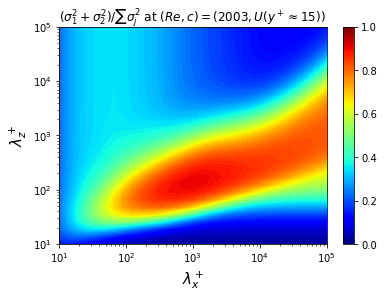

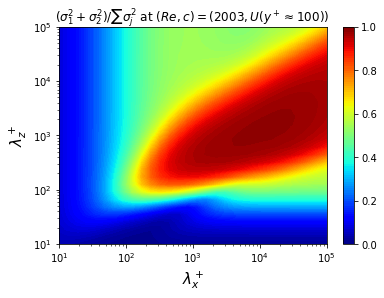

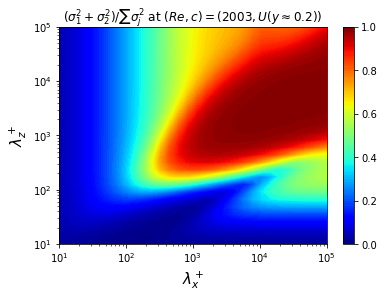

In [70]:
levels = np.linspace(0.,1.0,101)
cticks = np.linspace(0.,1.,6)

plt.contourf(lxpArr, lzpArr, svals2norm_state.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y^+\\approx 15))$")
plt.savefig(figureFolder+'svals12norm_yp15_JB.pdf',format='pdf')
plt.show()

plt.contourf(lxpArr, lzpArr, svals2norm_yp100_state.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y^+\\approx 100))$")
plt.savefig(figureFolder+'svals12norm_yp100_JB.pdf',format='pdf')
plt.show()

plt.contourf(lxpArr, lzpArr, svals2norm_y02_state.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y\\approx 0.2))$")
plt.savefig(figureFolder+'svals12norm_y02_JB.pdf',format='pdf')
plt.show()

# Optimal forcing response with eddy viscosity
Hwang & Cossu 2010 (JFM); Linear non-normal energy amplification ...

In [123]:
# First, amplification due to stochastic forcing
N=150; Re = 10000.
bArr = 10** np.linspace(-1., 4., 51)
aArr= np.array([0., 0.1, 0.2, 0.5, 1., 2., 5., 10.])
Varr = np.zeros((aArr.size, bArr.size)) # max ampl. 

for ind0 in range(aArr.size):
    a = aArr[ind0]
    for ind1 in range(bArr.size):
        b = bArr[ind1]
        N = np.int(200+ 75*np.log10(b))
        k2 = a**2 + b**2
        
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        
        A, C, B = statInst.makeSystem(nu=statInst.nu)
        Aadj, Cadj, Badj = statInst.makeAdjSystem(nu=statInst.nu)
        X = solve_sylvester(A, Aadj, - B @ Badj )
        
        Varr[ind0,ind1] = np.trace( C @ X @ Cadj )
        
        



Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=125
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0 0.1 10000.0
a, b, Re: 0.0 0.1 10000.0


/home/svadarevu/gitwork/linear/library/ops.py:190: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  Essentially, I define OSS*[vel,vor].T =: i.omega*[vel,vor].T
/home/svadarevu/linenv/lib/python3.5/site-packages/ipykernel/__main__.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=132
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0 0.125892541179 10000.0
a, b, Re: 0.0 0.125892541179 10000.0
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=140
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0 0.158489319246 10000.0
a, b, Re: 0.0 0.158489319246 10000.0
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=147
Initialized in

In [151]:
# Amplification due to harmonic forcing
N=150; Re = 10000.
bArr = 10** np.linspace(-1., 5., 31)
aArr= np.array([0., 0.1, 0.2, 0.5, 1., 2., 5., 10.])
#bArr = np.array([1000.]); aArr = np.array([0.])
Garr = np.zeros((aArr.size, bArr.size)) # max ampl. 
cArr = np.linspace(5., 25., 81)

for ind0 in range(aArr.size):
    a = aArr[ind0]
    for ind1 in range(bArr.size):
        b = bArr[ind1]
        k2 = a**2 + b**2
        N = np.int(200+ 75*np.log10(b))
        
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        A, C, B = statInst.makeSystem(nu = statInst.nu)
        I = np.identity(A.shape[0])
        
        GtmpArr = np.zeros(cArr.size)
        for ind2 in range(cArr.size):
            c = cArr[ind2]; omega = a*c

            R = (1.j*omega*I + A)
            R = -np.linalg.solve(R, I)
            H = C @ R @ B

            try:
                U,S,V = np.linalg.svd(H)
            except:
                print("SVD failed for a,b,c:",a,b,c)
            GtmpArr[ind2] = S[0]**2
        
        Garr[ind0, ind1] = np.max(GtmpArr)
        
        



Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=125
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0 0.1 10000.0


/home/svadarevu/gitwork/linear/library/ops.py:190: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  Essentially, I define OSS*[vel,vor].T =: i.omega*[vel,vor].T


Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=140
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0 0.158489319246 10000.0
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=155
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0 0.251188643151 10000.0
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=170
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module i

((8, 51), (31,))

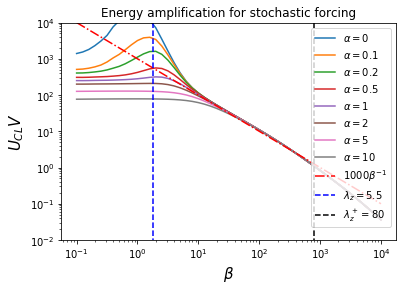

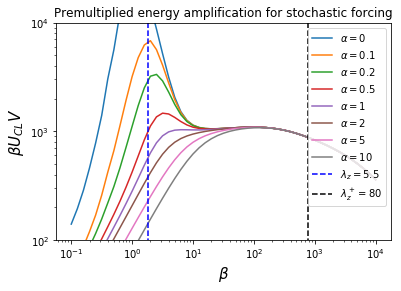

In [163]:
Ue = np.max(statInst.U)
#Ue = 12.5
bArr = 10.** np.linspace(-1.,4.,51)
for k in range(Varr.shape[0]):
    plt.plot(bArr, Ue*Varr[k])
plt.plot(bArr, 1000./bArr, 'r-.')
plt.plot(b0*np.ones(25), 10**np.linspace(-5,7,25), 'b--')
plt.plot(b0p*np.ones(25), 10**np.linspace(-5,7,25), 'k--')
plt.xscale("log") ; plt.yscale("log")
plt.xlabel("$\\beta$", fontsize=15); plt.ylabel("$U_{CL} V$",fontsize=15)
plt.title("Energy amplification for stochastic forcing")
legList = ['$\\alpha=$%.2g'%aa for aa in list(aArr)]
legList.append('$1000\\beta^{-1}$')
legList.append('$\\lambda_z=5.5$'); legList.append('$\\lambda_z^+=80$')
plt.legend(legList,loc=1)
plt.ylim([0.01, 10000])
plt.savefig(figureFolder+"ampStoEddy.pdf", format="pdf")
plt.show()

for k in range(Varr.shape[0]):
    plt.plot(bArr, Ue*bArr*Varr[k])
#plt.plot(bArr, 1000./bArr, 'r--')
plt.plot(b0*np.ones(25), 10**np.linspace(-5,7,25), 'b--')
plt.plot(b0p*np.ones(25), 10**np.linspace(-5,7,25), 'k--')
plt.xscale("log") ; plt.yscale("log")
plt.xlabel("$\\beta$", fontsize=15); plt.ylabel("$\\beta U_{CL} V$",fontsize=15)
plt.title("Premultiplied energy amplification for stochastic forcing")
legList = ['$\\alpha=$%.2g'%aa for aa in list(aArr)]
legList.append('$\\lambda_z=5.5$'); legList.append('$\\lambda_z^+=80$')
plt.legend(legList,loc=1)
plt.ylim([100, 10000])
plt.savefig(figureFolder+"preAmpStoEddy.pdf", format="pdf")
plt.show()

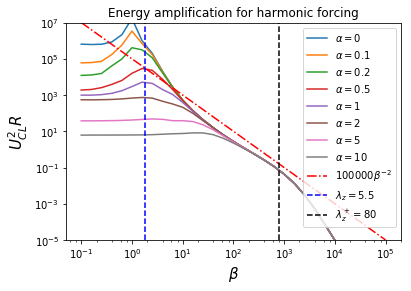

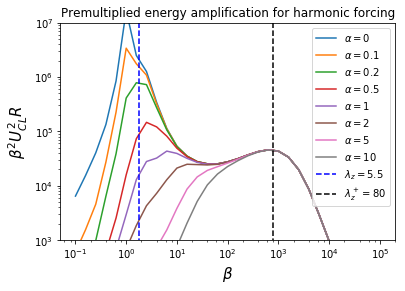

In [166]:
lz0 = 3.5; b0 = 2.*np.pi/lz0
lz0p = 80; b0p = 2.*np.pi/(lz0p/statInst.Re)
Ue = np.max(statInst.U)
bArr = 10.** np.linspace(-1.,5.,31)
for k in range(Garr.shape[0]):
    plt.plot(bArr, Ue**2 * Garr[k])
plt.plot(bArr, 100000./bArr**2, 'r-.')
plt.plot(b0*np.ones(25), 10**np.linspace(-5,7,25), 'b--')
plt.plot(b0p*np.ones(25), 10**np.linspace(-5,7,25), 'k--')
plt.xscale("log") ; plt.yscale("log")
plt.xlabel("$\\beta$", fontsize=15); plt.ylabel("$U^2_{CL} R$",fontsize=15)
plt.title("Energy amplification for harmonic forcing")
legList = ['$\\alpha=$%.2g'%aa for aa in list(aArr)]
legList.append('$100000\\beta^{-2}$')
legList.append('$\\lambda_z=5.5$'); legList.append('$\\lambda_z^+=80$')
plt.legend(legList,loc=1)
plt.ylim([1.0e-05, 1.0e07])
plt.savefig(figureFolder+"ampHarEddy.pdf", format="pdf")
plt.show()

for k in range(Garr.shape[0]):
    plt.plot(bArr, Ue**2 * bArr **2 * Garr[k])
plt.plot(b0*np.ones(25), 10**np.linspace(-5,7,25), 'b--')
plt.plot(b0p*np.ones(25), 10**np.linspace(-5,7,25), 'k--')
plt.xscale("log") ; plt.yscale("log")
plt.xlabel("$\\beta$", fontsize=15); plt.ylabel("$\\beta^2 U^2_{CL} R$",fontsize=15)
plt.title("Premultiplied energy amplification for harmonic forcing")
legList = ['$\\alpha=$%.2g'%aa for aa in list(aArr)]
#legList.append('$1000\\beta^{-2}$')
legList.append('$\\lambda_z=5.5$'); legList.append('$\\lambda_z^+=80$')
plt.legend(legList,loc=1)
plt.ylim([1.0e03, 1.0e07])
plt.savefig(figureFolder+"preAmpHarEddy.pdf", format="pdf")
plt.show()


In [129]:
Garr[:,0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00789716])

# Verify velocity vorticity to primitives and vice-versa

Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


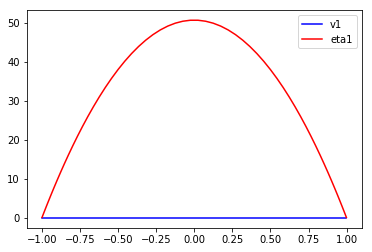

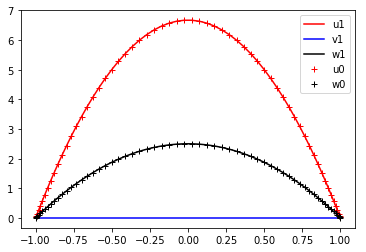

Divergence of uvw is  8.3664092105e-16
Difference in v from veta and uvw are 0.0


In [186]:
# We need two state-vectors first
# They have to be divergence free, and satisfy the BCs
# It's easier to ensure divergence-free condition if I start with velocity vorticity
statInst = ops.statComp(a=2.5, b=20./3., N=62, Re=186.)
a = statInst.a; b = statInst.b; N = statInst.N
y = statInst.y
# Doesn't matter what the exact functions are, as long as BCs are good
eta1 = 1.j*(a**2 + b**2) * (1. - y**2)
v1 = np.zeros(statInst.N)
# For the above field, u and w should be
u0 = b*(1.-y**2); w0 = -a*(1.-y**2)

veta1 = np.concatenate((v1, eta1))
uvw1 = statInst.velVor2primitivesMat(a=a,b=b) @ veta1

# Ensure that the divergence is actually zero
div1 = 1.j*a*uvw1[:N] + statInst.D1 @ uvw1[N:2*N] + 1.j*b*uvw1[2*N:3*N]

plt.plot(statInst.y, np.abs(veta1[0*N:1*N]), 'b')
plt.plot(statInst.y, np.abs(veta1[1*N:2*N]), 'r')
plt.legend(['v1','eta1', 'v2', 'eta2'])
plt.show()


plt.plot(statInst.y, np.abs(uvw1[0*N:1*N]), 'r')
plt.plot(statInst.y, np.abs(uvw1[1*N:2*N]), 'b')
plt.plot(statInst.y, np.abs(uvw1[2*N:3*N]), 'k')
plt.plot(statInst.y, np.abs(u0), 'r+')
plt.plot(statInst.y, np.abs(w0), 'k+')
plt.legend(['u1','v1','w1', 'u0', 'w0'])
plt.show()

print("Divergence of uvw is ", pseudo.chebnorm(div1,N))
print("Difference in v from veta and uvw are", 
      pseudo.chebnorm(veta1[:N]-uvw1[N:2*N], N))




# Norms for $[u,v,w] = [ \beta(1-y^2), 0, -\alpha(1-y^2) ]  $

The energy norm for this field should be $8(\alpha^2 + \beta^2)/15$

In [209]:
statInst = ops.statComp(a=2.5, b=20./3., N=62, Re=186.)
a = statInst.a; b = statInst.b; N = statInst.N
y = statInst.y
# Doesn't matter what the exact functions are, as long as BCs are good
eta = 1.j*(a**2 + b**2) * (1. - y**2)
v = np.zeros(statInst.N)
veta = np.concatenate((v,eta))
uvw = statInst.velVor2primitivesMat(a=a,b=b) @ veta
uvwWeighted = statInst._weightVec(uvw)

# Numpy's linalg norm definition takes a square-root that isn't needed
uvwNorm1 = np.linalg.norm(uvwWeighted)**2
uvwNorm2 = pseudo.chebnorm(uvw,N)**2

A,C,B = statInst.makeSystem()
state = B @ uvwWeighted

stateNorm1 = np.linalg.norm(state)**2
stateNorm2 = np.abs(np.sum(state * state.conj()))
stateNorm3 = np.dot(state, state.conj())

energyNorm = 8.*(a**2 + b**2)/15.

uvwWeighted_ = C @ state
tol = 1.0e-12
_approx = lambda scal1, scal2: np.abs(scal1-scal2) < tol

print();print();print()
print("Energy norm for the field should be ", energyNorm)
print("Is norm from unweighted uvw correct?\n\t", _approx(uvwNorm2, energyNorm))
print("Is norm from weighted uvw correct?\n\t", _approx(uvwNorm1, energyNorm))
print("Is norm from state (np.linalg.norm) correct?\n\t", _approx(stateNorm1, energyNorm))
print("Is norm from state (state*state.conj()) correct?\n\t", _approx(stateNorm2, energyNorm))
print("Is dot of state the same as norm?\n\t", _approx(stateNorm1, stateNorm3))

print("Diff between original weighted uvw and after going throw C then B:", 
     np.linalg.norm(uvwWeighted - uvwWeighted_))




Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666667 186.0



Energy norm for the field should be  27.03703703703704
Is norm from unweighted uvw correct?
	 True
Is norm from weighted uvw correct?
	 True
Is norm from state (np.linalg.norm) correct?
	 True
Is norm from state (state*state.conj()) correct?
	

/home/svadarevu/gitwork/linear/library/ops.py:190: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  Essentially, I define OSS*[vel,vor].T =: i.omega*[vel,vor].T


# Verifying adjoint matrices from definition
I have some confusion regarding adjoint operators, which mainly stems from having states and outputs that aren't the same as the velocity field, and having to define dots and norms operating on these. 

In the end, the norm I'm using in statInst is just the standard Euclidean norm, so the adjoints will also have to be defined such that they are given by conjugate transposes. 

Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


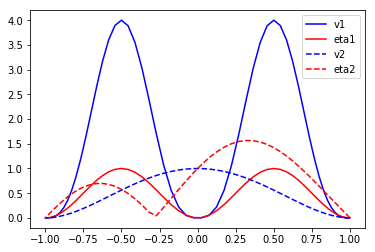

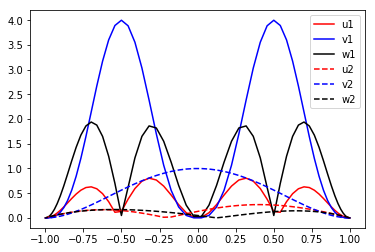

Divergences for the two fields are  2.51530736476e-14 5.93385466217e-15
Differences in v from veta and uvw are 0.0 0.0


In [202]:
# We need two state-vectors first
# They have to be divergence free, and satisfy the BCs
# It's easier to ensure divergence-free condition if I start with velocity vorticity
statInst = ops.statComp(a=2.5, b=20./3., N=62, Re=186.)
a = statInst.a; b = statInst.b; N = statInst.N
y = statInst.y
# Doesn't matter what the exact functions are, as long as BCs are good
# On eta, it's just eta(walls) = 0, but on v, it's both v=0 and v'=0
#eta1 = 1. - statInst.y**2 - (1. - statInst.y**4)**2
eta1 = (np.sin(np.pi*y))**2
eta2 = np.sin(np.pi*y) + (1. - y**2)**3
v1 =  -3.*np.sin(np.pi*y) + np.sin(3.*np.pi*y)
v2 = 2.*(1. - y**2) - (1. - y**4)

veta1 = np.concatenate((v1, eta1))
veta2 = np.concatenate((v2, eta2))
uvw1 = statInst.velVor2primitivesMat(a=a,b=b) @ veta1
#uvw1 = np.concatenate((1.-y**2, 0.*y, -1.+y**2))
uvw2 = statInst.velVor2primitivesMat(a=a,b=b) @ veta2

# Ensure that the divergence is actually zero
div1 = 1.j*a*uvw1[:N] + statInst.D1 @ uvw1[N:2*N] + 1.j*b*uvw1[2*N:3*N]
div2 = 1.j*a*uvw2[:N] + statInst.D1 @ uvw2[N:2*N] + 1.j*b*uvw2[2*N:3*N]

plt.plot(statInst.y, np.abs(veta1[0*N:1*N]), 'b')
plt.plot(statInst.y, np.abs(veta1[1*N:2*N]), 'r')
plt.plot(statInst.y, np.abs(veta2[0*N:1*N]), 'b--')
plt.plot(statInst.y, np.abs(veta2[1*N:2*N]), 'r--')
plt.legend(['v1','eta1', 'v2', 'eta2'])
plt.show()


plt.plot(statInst.y, np.abs(uvw1[0*N:1*N]), 'r')
plt.plot(statInst.y, np.abs(uvw1[1*N:2*N]), 'b')
plt.plot(statInst.y, np.abs(uvw1[2*N:3*N]), 'k')
plt.plot(statInst.y, np.abs(uvw2[0*N:1*N]), 'r--')
plt.plot(statInst.y, np.abs(uvw2[1*N:2*N]), 'b--')
plt.plot(statInst.y, np.abs(uvw2[2*N:3*N]), 'k--')
plt.legend(['u1','v1','w1', 'u2', 'v2', 'w2'])
plt.show()

print("Divergences for the two fields are ", pseudo.chebnorm(div1,N), pseudo.chebnorm(div2,N))
print("Differences in v from veta and uvw are", 
      pseudo.chebnorm(veta1[:N]-uvw1[N:2*N], N), pseudo.chebnorm(veta2[:N]-uvw2[N:2*N], N))



In [215]:
uvw1Weighted = statInst._weightVec(uvw1)
uvw2Weighted = statInst._weightVec(uvw2)

A,C,B = statInst.makeSystem()
Aadj, Cadj, Badj = statInst.makeAdjSystem()
AH = A.conj().T; BH = B.conj().T; CH = C.conj().T
state1 = B @ uvw1Weighted
state2 = B @ uvw2Weighted
assert state1.ndim==1 and state2.ndim==1

def _dot(vec1,vec2): 
    assert (vec1.ndim==1) and (vec2.ndim==1)
    return np.abs(np.sum( vec1 * vec2.conj() ))
tol = 1.0e-12
_approx = lambda scal1, scal2: np.abs(scal1-scal2) < tol

print("Are A, Aadj an adjoint pair (auto):", 
      _approx( _dot(A@state1, state1), _dot(state1, Aadj@state1) )  )
print("Are A, Aadj an adjoint pair (cross):", 
      _approx( _dot(A@state1, state2), _dot(state1, Aadj@state2) )  )
print("Are A, AH an adjoint pair (auto):", 
      _approx( _dot(A@state1, state1), _dot(state1, AH@state1) )  )
print("Are A, AH an adjoint pair (cross):", 
      _approx( _dot(A@state1, state2), _dot(state1, AH@state2) )  )



print("Are C, Cadj an adjoint pair (auto):", 
      _approx( _dot(C@state1, uvw1Weighted), _dot(state1, Cadj@uvw1Weighted) )  )
print("Are C, Cadj an adjoint pair (cross):", 
      _approx( _dot(C@state1, uvw2Weighted), _dot(state1, Cadj@uvw2Weighted) )  )
print("Are C, CH an adjoint pair (auto):", 
      _approx( _dot(C@state1, uvw1Weighted), _dot(state1, CH@uvw1Weighted) )  )
print("Are C, CH an adjoint pair (cross):", 
      _approx( _dot(C@state1, uvw2Weighted), _dot(state1, CH@uvw2Weighted) )  )



print("Are B, Badj an adjoint pair (auto):", 
      _approx( _dot(state1, B@uvw1Weighted), _dot(Badj@state1, uvw1Weighted) )  )
print("Are B, Badj an adjoint pair (cross):", 
      _approx( _dot(state1, B@uvw2Weighted), _dot(Badj@state1, uvw2Weighted) )  )
print("Are B, BH an adjoint pair (auto):", 
      _approx( _dot(state1, B@uvw1Weighted), _dot(BH@state1, uvw1Weighted) )  )
print("Are B, BH an adjoint pair (cross):", 
      _approx( _dot(state1, B@uvw2Weighted), _dot(BH@state1, uvw2Weighted) )  )







a, b, Re: 2.5 6.666666666666667 186.0
a, b, Re: 2.5 6.666666666666667 186.0
Are A, Aadj an adjoint pair (auto): False
Are A, Aadj an adjoint pair (cross): False
Are A, AH an adjoint pair (auto): True
Are A, AH an adjoint pair (cross): True
Are C, Cadj an adjoint pair (auto): True
Are C, Cadj an adjoint pair (cross): True
Are C, CH an adjoint pair (auto): True
Are C, CH an adjoint pair (cross): True
Are B, Badj an adjoint pair (auto): True
Are B, Badj an adjoint pair (cross): True
Are B, BH an adjoint pair (auto): True
Are B, BH an adjoint pair (cross): True


/home/svadarevu/gitwork/linear/library/ops.py:190: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  Essentially, I define OSS*[vel,vor].T =: i.omega*[vel,vor].T


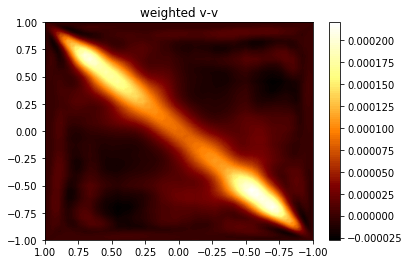

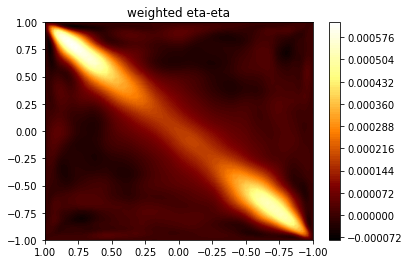

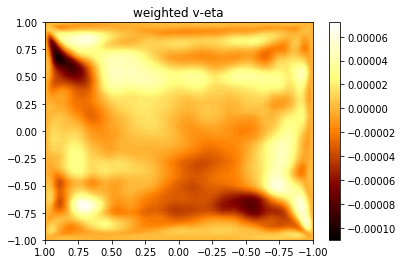

In [229]:
Phi = 4.*statInst.covMat/(0.25*2./3.)
X = B @ Phi @ B.conj().T
plt.contourf(y, y, np.real(X[:N,:N]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("weighted v-v")
plt.show()

plt.contourf(y, y, np.real(X[N:,N:]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("weighted eta-eta")
plt.show()

plt.contourf(y, y, np.real(X[:N,N:]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("weighted v-eta")
plt.show()


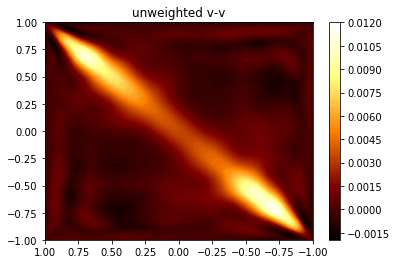

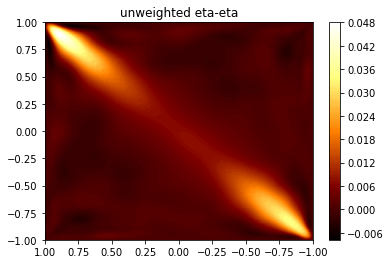

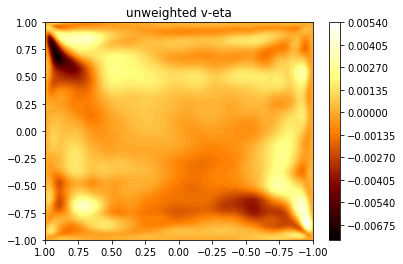

In [230]:
qInv = 1./np.sqrt(statInst.w)
Qinv = np.diag( np.concatenate((qInv,qInv)))
Xun = Qinv @ X @ Qinv
plt.contourf(y, y, np.real(Xun[:N,:N]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("unweighted v-v")
plt.show()

plt.contourf(y, y, np.real(Xun[N:,N:]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("unweighted eta-eta")
plt.show()

plt.contourf(y, y, np.real(Xun[:N,N:]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("unweighted v-eta")
plt.show()


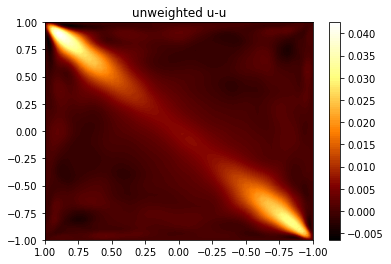

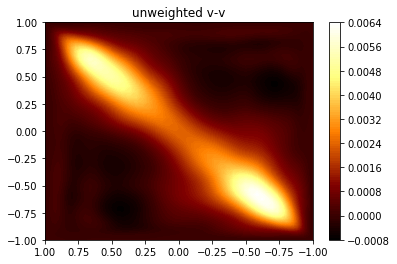

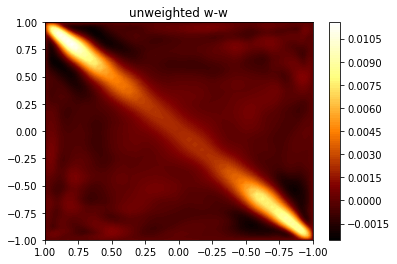

In [225]:

qInv = 1./np.sqrt(statInst.w)
Qinv = np.diag( np.concatenate((qInv,qInv,qInv)))
PhiUn = Qinv @ Phi @ Qinv
plt.contourf(y, y, np.real(PhiUn[:N,:N]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("unweighted u-u")
plt.show()

plt.contourf(y, y, np.real(PhiUn[N:2*N,N:2*N]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("unweighted v-v")
plt.show()

plt.contourf(y, y, np.real(PhiUn[2*N:3*N,2*N:3*N]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("unweighted w-w")
plt.show()


# Testing $X = B \Phi B^*$ with test fields
The reason for doing this is, when I look at Phi[N:2N,N:2N] and X[:N,:N], which should both correspond to v-v covariance, they don't seem to match.

In [242]:
statInst = ops.statComp(a=2.5, b=20./3., N=62, Re=186.)
a = statInst.a; b = statInst.b; N = statInst.N
y = statInst.y
# Doesn't matter what the exact functions are, as long as BCs are good
# On eta, it's just eta(walls) = 0, but on v, it's both v=0 and v'=0
#eta1 = 1. - statInst.y**2 - (1. - statInst.y**4)**2
eta1 = (np.sin(np.pi*y))**2
eta2 = np.sin(np.pi*y) + (1. - y**2)**3
v1 =  -3.*np.sin(np.pi*y) + np.sin(3.*np.pi*y)
v2 = 2.*(1. - y**2) - (1. - y**4)

veta1 = np.concatenate((v1, eta1))
veta2 = np.concatenate((v2, eta2))
uvw1 = statInst.velVor2primitivesMat(a=a,b=b) @ veta1
#uvw1 = np.concatenate((1.-y**2, 0.*y, -1.+y**2))
uvw2 = statInst.velVor2primitivesMat(a=a,b=b) @ veta2

vel1 = statInst._weightVec(uvw1).reshape((uvw1.size,1))
vel2 = statInst._weightVec(uvw2).reshape((uvw2.size,1))

Phi1 = vel1 @ vel1.conj().T
Phi2 = vel2 @ vel2.conj().T

A,C,B = statInst.makeSystem()
state1 = B @ vel1.flatten()
state2 = B @ vel2.flatten()
X1 = B @ Phi1 @ B.conj().T
X2 = B @ Phi2 @ B.conj().T

vCovDiff1 = np.linalg.norm((Phi1[N:2*N, N:2*N] - X1[:N,:N]).flatten())**2
vCovDiff2 = np.linalg.norm((Phi2[N:2*N, N:2*N] - X2[:N,:N]).flatten())**2

vDiff1 = np.linalg.norm(vel1[N:2*N,0] - state1[:N])
vDiff2 = np.linalg.norm(vel2[N:2*N,0] - state2[:N])
#vDiff1 = np.linalg.norm(vel1[2*N:3*N,0] - state1[:N])
#vDiff2 = np.linalg.norm(vel2[2*N:3*N,0] - state2[:N])

print("vCovDiff1, vCovDiff2:", vCovDiff1, vCovDiff2)
print("vDiff1, vDiff2:", vDiff1, vDiff2)

Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666667 186.0
vCovDiff1, vCovDiff2: 4.41130273739 0.000839435949155
vDiff1, vDiff2: 0.497334122243 0.0256502439589


/home/svadarevu/gitwork/linear/library/ops.py:190: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")


So, the first 'N' elements in the state are NOT the same as the N-2N elements in the (weighted) velocity vector!

In [244]:
Phi11 = C @ X1 @ C.conj().T
np.linalg.norm(Phi1 - Phi11, ord='fro')

2.9595057641185716e-14

In the end, I do recover $\Phi$ from $X$ using B and C

It's just that comparing the v-v sub-block in $\Phi$ to that in $X$ is wrong.